# Data Exploration

In the Data exploration phase, we use a visual exploration to understand what is in a dataset and the characteristics of the data. These characteristics can include the size or amount of data, completeness of the data, correctness of the data and possible relationships amongst the different files in the data.

In this first notebook, we'll be exploring the raw HAR data that was provided to us. We'll review the data format and assess whether the provided data is e.g. well-balanced & high quality. 

Import the required libraries to perform the data exploration.

In [2]:
import re as re
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from IPython.display import display

## Raw data

we will first focus on the raw sensor data exploration. In the next section, we will also investigate the HAR dataset. The next two notebooks, 'Signal Processing' and 'Feature Engineering' will explain how the HAR dataset was created from the raw sensor data.

### Data Loading

Define the location of the raw data files.

In [3]:
raw_data = "../data/HAPT Data Set/RawData/*.txt"
raw_data_paths = glob(raw_data)
acc_files = [file for file in raw_data_paths if "acc" in file]
gyro_files = [file for file in raw_data_paths if "gyro" in file]
label_files = [file for file in raw_data_paths if "labels" in file]
print(f"The folder contains {len(acc_files)} acceleration files, {len(gyro_files)} gyroscope files and {len(label_files)} label file")

The folder contains 61 acceleration files, 61 gyroscope files and 1 label file


Load the raw data into a Pandas DataFrame.

In [4]:
def read_raw_data(files, columns):
    """"read raw data from the list of files and specified columns"""
    extra_cols = []
    dfs = [pd.read_csv(f, sep=' ', header=None) for f in files]
    for idx, df in enumerate(dfs):
        filename = files[idx].split("/")[-1]
        ints = list(map(int, re.findall(r'\d+', filename)))
        if len(ints)>0:
            df["experiment_number_ID"] = ints[0]
            df["user_number_ID"] = ints[1]
            df['timestamp'] = df.index
            extra_cols = ["experiment_number_ID", "user_number_ID", "timestamp"]
        dfs[idx] = df
    if len(extra_cols)>0:
        columns+=extra_cols
    df  = pd.concat(dfs, ignore_index=True)
    df.columns = columns 
    return df

raw_acc_columns=['acc_X','acc_Y','acc_Z']
raw_gyro_columns=['gyro_X','gyro_Y','gyro_Z']
raw_labels_columns=['experiment_number_ID','user_number_ID','activity_number_ID','label_start_point','label_end_point']

acc_df = read_raw_data(acc_files, raw_acc_columns)
gyro_df = read_raw_data(gyro_files, raw_gyro_columns)
label_df = read_raw_data(label_files, raw_labels_columns)

print(f"acc_df contains {len(acc_df)} rows, gyro_df contains {len(gyro_df)} rows and label_df contains {len(label_df)} rows ")

acc_df contains 1122772 rows, gyro_df contains 1122772 rows and label_df contains 1214 rows 


Based on this initial assessment, we can conclude that the accelerator and gyroscope sensor data don't have missing time periods. Missing data periods might occur in real-life systems if a sensor is faulty. We also have 1214 labeled periods, which we'll investigate later.

Define the activity dictionary for later use. We will only focus on the first 6 basic activities (BA's), and not on the postural transition activities (PTA's), the reason will be explained later.

In [5]:
activity_dict={
        1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', 
        4: 'SITTING', 5: 'STANDING', 6: 'LYING', 
        7: 'STAND_TO_SIT',  8: 'SIT_TO_STAND',  9: 'SIT_TO_LIE', 10: 'LIE_TO_SIT', 
        11: 'STAND_TO_LIE', 12: 'LIE_TO_STAND',
       }

### Data Understanding

What is in the sensor data? Let's investigate the first some of the rows of the accelerator data. The gyroscope data follows the same format.

In [7]:
acc_df.loc[acc_df['experiment_number_ID'] == 34]

,acc_X,acc_Y,acc_Z,experiment_number_ID,user_number_ID,timestamp
572597,0.188889,-0.016667,1.019445,34,17,0
572598,0.188889,-0.016667,1.019445,34,17,1
572599,0.229167,-0.022222,1.031945,34,17,2
572600,0.238889,-0.027778,1.013889,34,17,3
572601,0.219444,-0.015278,0.972222,34,17,4
...,...,...,...,...,...,...
593895,0.262500,0.368056,0.930556,34,17,21298
593896,0.263889,0.390278,0.947222,34,17,21299
593897,0.231944,0.373611,0.937500,34,17,21300
593898,0.229167,0.359722,0.920833,34,17,21301


'acc_X', 'acc_Y' and 'acc_Z' are the triaxial sensor values. The 'experiment_number_ID' and 'user_number_ID' indicates for which experiment and user the data was recorded. 
Let's investigate the range of sensor values. These are raw sensor values, so we can expect them to be quite noisy.

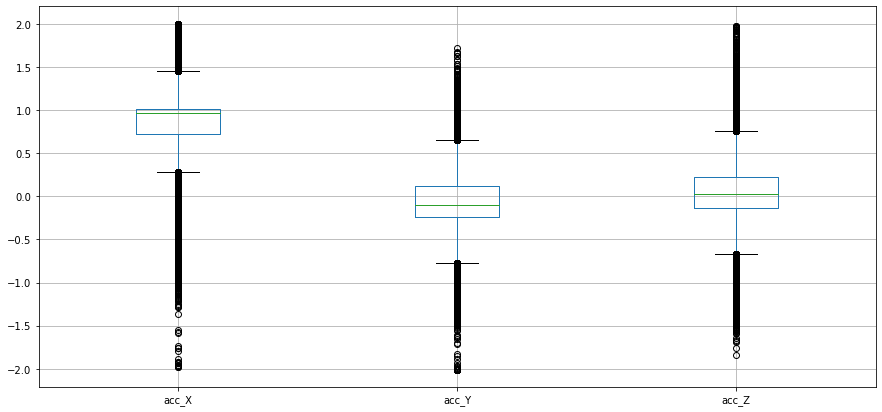

In [8]:
acc_df.boxplot(['acc_X', 'acc_Y', 'acc_Z'], figsize=(15,7))

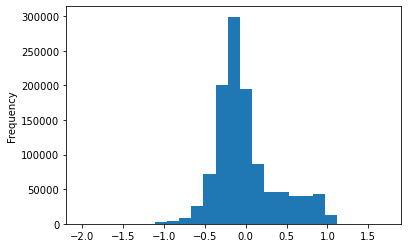

In [9]:
acc_df.acc_Y.plot(kind='hist', bins=25)

Overall, the sensor data follows a normal distribution, and outlier removal or data cleanup is probably not required.

What is in the label data? Let's investigate the first 10 rows.

In [12]:
label_df.head(10)

,experiment_number_ID,user_number_ID,activity_number_ID,label_start_point,label_end_point
0,1,1,5,250,1232
1,1,1,7,1233,1392
2,1,1,4,1393,2194
3,1,1,8,2195,2359
4,1,1,5,2360,3374
5,1,1,11,3375,3662
6,1,1,6,3663,4538
7,1,1,10,4539,4735
8,1,1,4,4736,5667
9,1,1,9,5668,5859


The label data contains the identifiers of each experiment and user. It also contains the activity label for each time period. In each experiment, several activities have been performed. Let's investigate how many experiments we have per user, and how many activities per experiment.

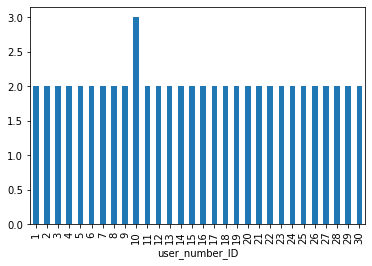

In [13]:
label_df.groupby("user_number_ID").experiment_number_ID.nunique().plot(kind='bar')

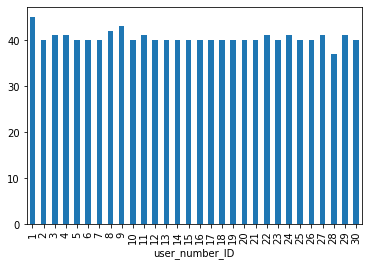

In [10]:
label_df.groupby("user_number_ID").activity_number_ID.count().plot(kind='bar')

We observe there are 30 users (as expected) who performed on average 2 experiments (only 1 user performed 3 experiments). We also observe that each user performed approximately 40 activities (both BA's and PTA's). Let's investigate the average duration of each activity

In [11]:
label_df["label_duration"] = label_df["label_end_point"] - label_df["label_start_point"]

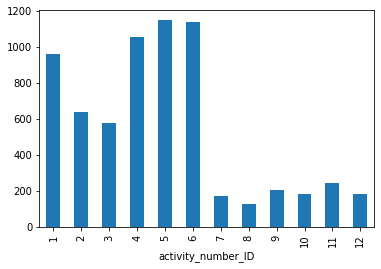

In [12]:
label_df.groupby("activity_number_ID").label_duration.mean().plot(kind='bar')

As expected, the basic activities are longer than the transition activities.

#### Summary

The data is well-balanced across the different users and activities. Each user has performed a similar number of experiments and activities. Some activities are significantly longer than others, which we'll have to take into account when featurizing the data.

The sensor data does not contain significant outliers and does not require additional cleaning prior to our analysis.

### Data Visualisation

Let's visualize the acceleration and gyroscope sensor data for two different activities for a single user in time.

We first define a helper function to visualize the triaxial signals.

In [13]:
def visualize_triaxial_signals(label_df, acc_df, gyro_df, user_number_ID=1, activity_number_ID=6, experiment_number_ID=1, sampling_freq=50):
    user_df = label_df[label_df.user_number_ID==user_number_ID]
    user_df = user_df[user_df.activity_number_ID==activity_number_ID]
    user_df = user_df[user_df.experiment_number_ID==experiment_number_ID]
    
    acc_df = acc_df[acc_df.experiment_number_ID.isin(user_df.experiment_number_ID) & acc_df.user_number_ID.isin(user_df.user_number_ID)]
    acc_df = acc_df[acc_df.timestamp.between(user_df.label_start_point.values[0], user_df.label_end_point.values[0])]
    gyro_df = gyro_df[gyro_df.experiment_number_ID.isin(user_df.experiment_number_ID) & gyro_df.user_number_ID.isin(user_df.user_number_ID)]
    gyro_df = gyro_df[gyro_df.timestamp.between(user_df.label_start_point.values[0], user_df.label_end_point.values[0])]

    len_df=user_df.label_duration.values[0]+1
    time=[1/float(sampling_freq) *j for j in range(len_df)]

    plt.figure(figsize=(18,5))
    plt.plot(time, acc_df.acc_X, label='acc_X', color='red')
    plt.plot(time, acc_df.acc_Y, label='acc_Y', color='green')
    plt.plot(time, acc_df.acc_Z, label='acc_Z', color='blue')
    plt.xlabel('Time in seconds (s)')
    plt.ylabel('Acceleration in 1g')
    plt.show()
    
    plt.figure(figsize=(18,5))
    plt.plot(time, gyro_df.gyro_X, label='gyro_X', color='red')
    plt.plot(time, gyro_df.gyro_Y, label='gyro_Y', color='green')
    plt.plot(time, gyro_df.gyro_Z, label='gyro_Z', color='blue')
    plt.xlabel('Time in seconds (s)') 
    plt.ylabel('Angular Velocity in radian per second [rad/s]')
    plt.show()

Let's visualize two lying and two walking signals.

#### LYING

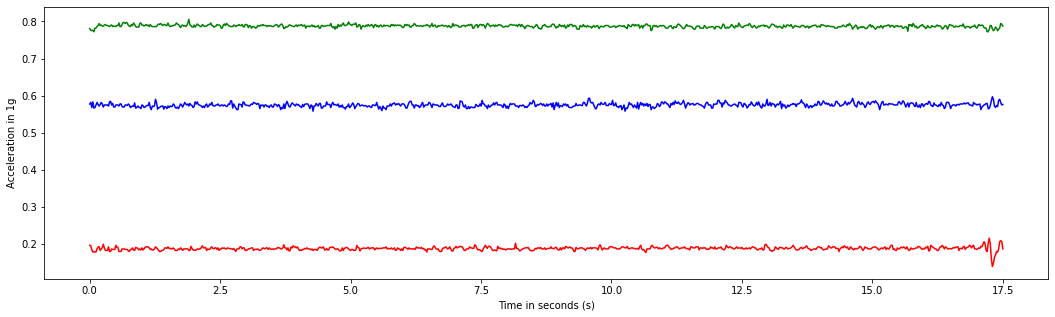

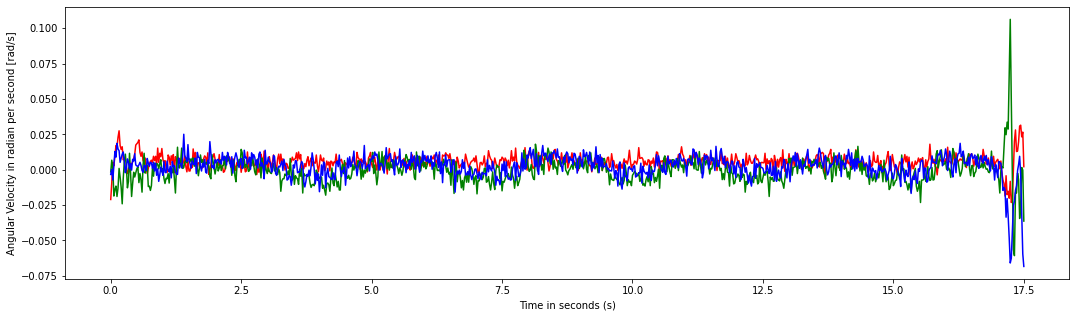

In [14]:
visualize_triaxial_signals(label_df, acc_df, gyro_df, user_number_ID=1, activity_number_ID=6, experiment_number_ID=1)

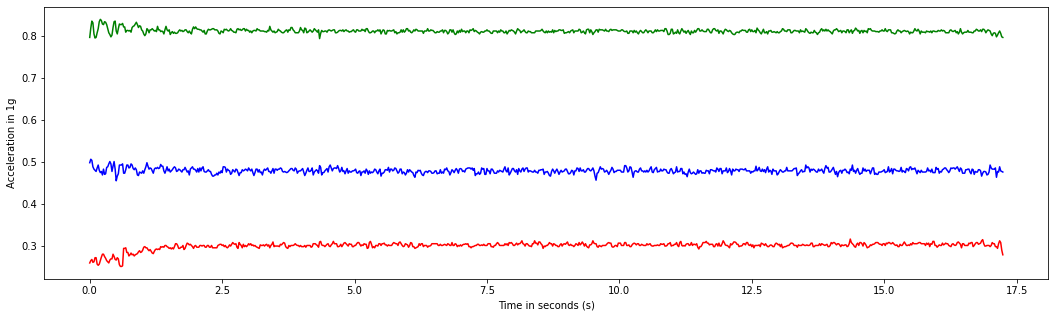

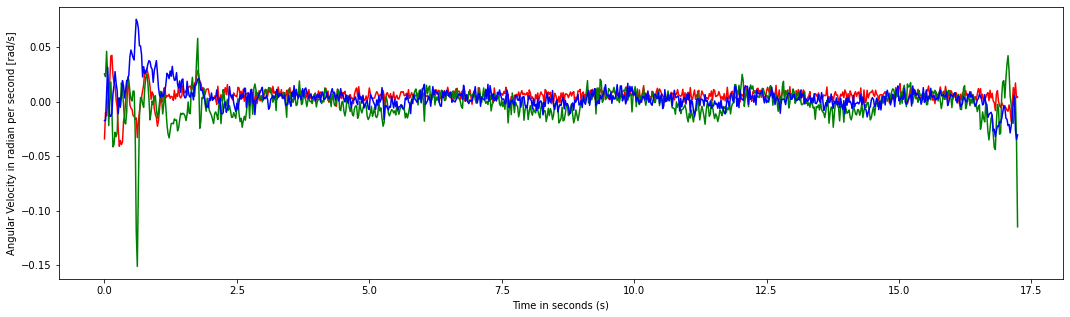

In [15]:
visualize_triaxial_signals(label_df, acc_df, gyro_df, user_number_ID=1, activity_number_ID=6, experiment_number_ID=2)

#### WALKING

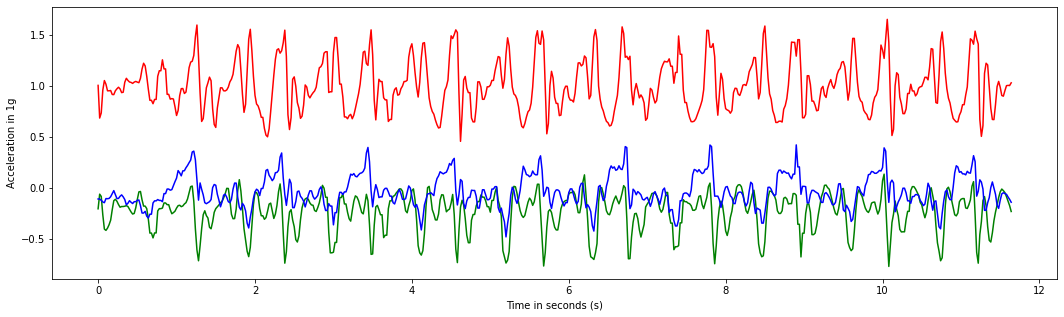

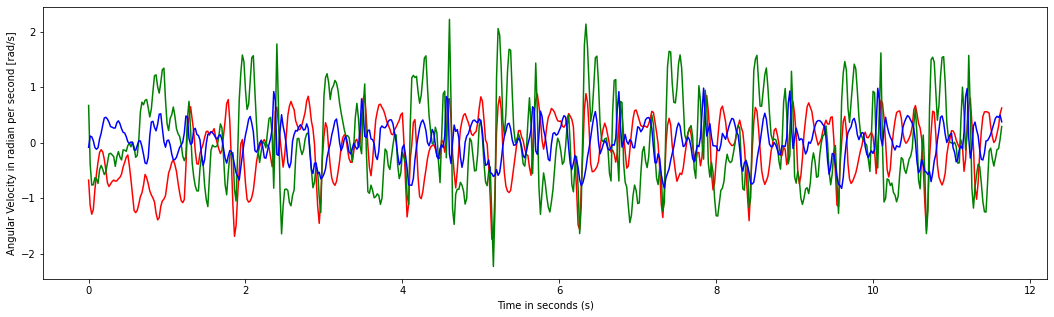

In [16]:
visualize_triaxial_signals(label_df, acc_df, gyro_df, user_number_ID=1, activity_number_ID=1, experiment_number_ID=1)

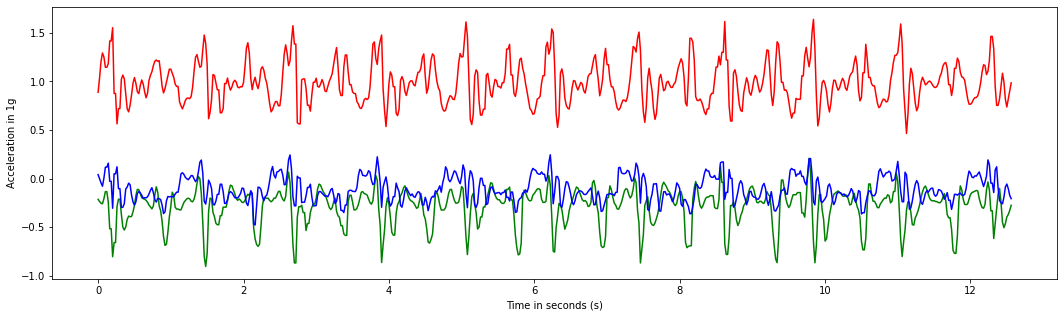

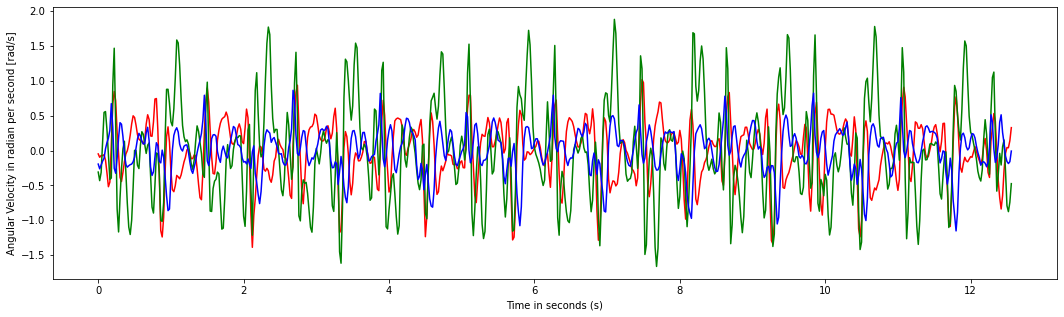

In [17]:
visualize_triaxial_signals(label_df, acc_df, gyro_df, user_number_ID=1, activity_number_ID=1, experiment_number_ID=2)

As expected, walking triaxial signals are more volatile compared to lying triaxial signals. Additionally, when looking at the time series, it is clear that the sensors capture a lot of noise, which is not relevant for the problem we are trying to solve. 

In the next notebooks, we'll investigate different techniques that can be used to clean the data through signal processing techniques. Additionally, we'll look at feature engineering techniques that process our data from a time-series signal, into a set of features that are computed for fixed-length time windows. Finally, we'll build a classifier that classifies the activity corresponding to each time window.

## HAR dataset

The signal processing and feature engineering work has already been performed by the team that created the HAR dataset. They've applied signal processing, time-windowing and feature engineering to create a dataset that is ready for machine learning modeling.

The dataset is split based on the subjects into train and test. Each split contains the feature data (features calculated on each time window), the window label (the activity of the window) as well as the subject data (the subject that corresponds to each window).

### Data Loading

Define the location of the dataset files.

In [18]:
train_data = "../data/HAPT Data Set/Train/X_train.txt"
train_labels = "../data/HAPT Data Set/Train/y_train.txt"
train_subjects = "../data/HAPT Data Set/Train/subject_id_train.txt"

test_data = "../data/HAPT Data Set/Test/X_test.txt"
test_labels = "../data/HAPT Data Set/Test/y_test.txt"
test_subjects = "../data/HAPT Data Set/Test/subject_id_test.txt"

feature_names = "../data/HAPT Data Set/features.txt"

Load the dataset into a Pandas DataFrame.

In [19]:
def read_dataset_data(data, labels, subjects, feature_names):
    feature_names = open(feature_names).read().splitlines()
    feature_names = [feature.replace(' ', '')+f"_{idx}" for idx, feature in enumerate(feature_names)]

    X = pd.read_csv(data, sep=" ", header=None, names=feature_names)
    y = pd.read_csv(labels, sep=" ", header=None, names=['activity_label'])
    subjects = pd.read_csv(subjects, sep=" ", header=None, names=["subjects"])

    return X, y, subjects

X_train, y_train, subject_train = read_dataset_data(train_data, train_labels, train_subjects, feature_names)
X_test, y_test, subject_test = read_dataset_data(test_data, test_labels, test_subjects, feature_names)

### Data Understanding

What is in the dataset? Let's investigate the train data, as we can assume the test data follows the same assumptions.

In [20]:
X_train.head(10)

,tBodyAcc-Mean-1_0,tBodyAcc-Mean-2_1,tBodyAcc-Mean-3_2,tBodyAcc-STD-1_3,tBodyAcc-STD-2_4,tBodyAcc-STD-3_5,tBodyAcc-Mad-1_6,tBodyAcc-Mad-2_7,tBodyAcc-Mad-3_8,tBodyAcc-Max-1_9,...,fBodyGyroJerkMag-MeanFreq-1_551,fBodyGyroJerkMag-Skewness-1_552,fBodyGyroJerkMag-Kurtosis-1_553,tBodyAcc-AngleWRTGravity-1_554,tBodyAccJerk-AngleWRTGravity-1_555,tBodyGyro-AngleWRTGravity-1_556,tBodyGyroJerk-AngleWRTGravity-1_557,tXAxisAcc-AngleWRTGravity-1_558,tYAxisAcc-AngleWRTGravity-1_559,tZAxisAcc-AngleWRTGravity-1_560
0,0.043580,-0.005970,-0.035054,-0.995381,-0.988366,-0.937382,-0.995007,-0.988816,-0.953325,-0.794796,...,-0.012236,-0.314848,-0.713308,-0.112754,0.030400,-0.464761,-0.018446,-0.841559,0.179913,-0.051718
1,0.039480,-0.002131,-0.029067,-0.998348,-0.982945,-0.971273,-0.998702,-0.983315,-0.974000,-0.802537,...,0.202804,-0.603199,-0.860677,0.053477,-0.007435,-0.732626,0.703511,-0.845092,0.180261,-0.047436
2,0.039978,-0.005153,-0.022651,-0.995482,-0.977314,-0.984760,-0.996415,-0.975835,-0.985973,-0.798477,...,0.440079,-0.404427,-0.761847,-0.118559,0.177899,0.100699,0.808529,-0.849230,0.180610,-0.042271
3,0.039785,-0.011809,-0.028916,-0.996194,-0.988569,-0.993256,-0.996994,-0.988526,-0.993135,-0.798477,...,0.430891,-0.138373,-0.491604,-0.036788,-0.012892,0.640011,-0.485366,-0.848947,0.181907,-0.040826
4,0.038758,-0.002289,-0.023863,-0.998241,-0.986774,-0.993115,-0.998216,-0.986479,-0.993825,-0.801982,...,0.137735,-0.366214,-0.702490,0.123320,0.122542,0.693578,-0.615971,-0.848164,0.185124,-0.037080
5,0.038988,0.004109,-0.017340,-0.997438,-0.993485,-0.996692,-0.997522,-0.993494,-0.996916,-0.801982,...,0.074999,-0.554902,-0.844224,0.082632,-0.143439,0.275041,-0.368224,-0.849927,0.184795,-0.035326
6,0.039897,-0.005324,-0.020457,-0.997024,-0.977313,-0.987782,-0.996898,-0.977450,-0.989391,-0.800606,...,0.191486,-0.235576,-0.571126,-0.212754,-0.230622,0.014637,-0.189512,-0.852441,0.182142,-0.036203
7,0.039082,-0.016047,-0.030241,-0.996662,-0.976996,-0.986672,-0.996380,-0.977594,-0.989310,-0.800606,...,0.182731,-0.104337,-0.432022,-0.020888,0.593996,-0.561871,0.467383,-0.851309,0.183751,-0.035176
8,0.039026,-0.007410,-0.027301,-0.997431,-0.973190,-0.988183,-0.997491,-0.971557,-0.990156,-0.800245,...,0.347118,-0.286366,-0.579474,0.012954,0.080936,-0.234313,0.117797,-0.848270,0.188955,-0.030594
9,0.040354,0.004245,-0.017932,-0.994906,-0.981181,-0.990046,-0.995300,-0.982483,-0.990920,-0.799717,...,0.303948,0.306076,0.115919,-0.020590,-0.127730,-0.482871,-0.070670,-0.848592,0.190283,-0.027667


In [21]:
y_train.head(10)

,activity_label
0,5
1,5
2,5
3,5
4,5
5,5
6,5
7,5
8,5
9,5


In [22]:
subject_train.head(10)

,subjects
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1
9,1


The dataset allows us to link each time window (a set of features) back to a subject and an activity. We'll have a closer look at the distribution of the features and their distribution in the 'Modeling' notebook.

### Data Visualisation

Let's visualize the subjects and labels data distribution to verify we still have a high-quality dataset. We'll also look at some of the features. A more thorough analysis of the features follows later.

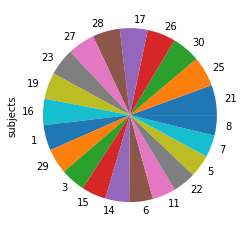

In [23]:
subject_train.subjects.value_counts().plot.pie()

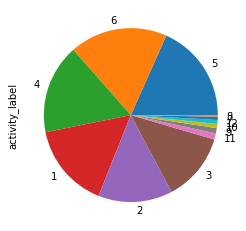

In [24]:
y_train.activity_label.value_counts().plot.pie()

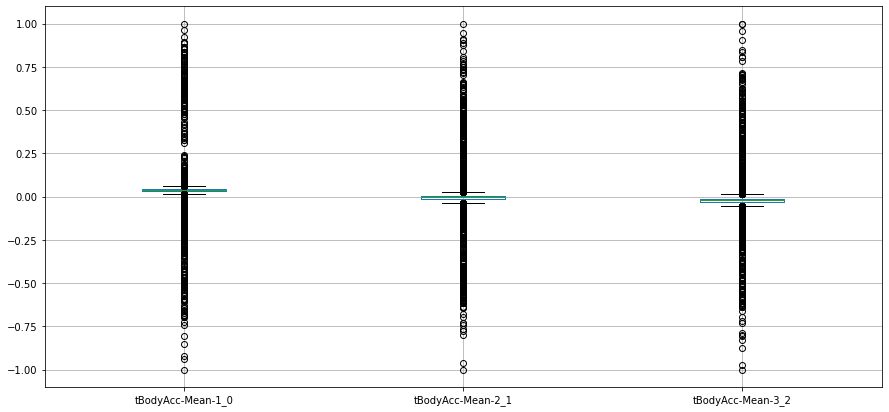

In [25]:
cols = X_train.columns.values[0:3]
cols = [str(col) for col in cols]
X_train.boxplot(cols, figsize=(15,7))

## Conclusion

In the Data Exploration phase, we used different visuals understand what is available in the data. We've investigated the amount of data, completeness of the data, correctness of the data and possible relationships amongst the different files in the data.